# CSE 5520 Homework 7

"Visualization of GMM and EM"

| | |
|-|-|
| **Student** | Lynn Pepin ('Tristan Pepin')
|              | tmp13009 / 2079724
| **Due date** | 2021 / Oct / 30 (Sun), 11:59PM
| | ('Sun' should be 'Sat', per HuskyCT due date)

This homework is to help you practice with some data visualization fundamentals.
You are expected to use these visualization techniques and others in your final project.
You are required to do this exercise in Python.

All plots/graphs must have titles and x-y coordinate tick labels. 

In [42]:
# Common imports from Python standard libraries
from dataclasses import dataclass
import math

# Common imports from
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats
from scipy import cluster
from statistics import mean
from sklearn.neighbors import KernelDensity
import sklearn.metrics
from scipy.stats import gaussian_kde
import time

# Useful imports for visualization
import seaborn

# Other packages
import networkx as nx
import pyvis as pv

# Used for Part 1
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go

# Constants
EPS = 0.0000001
FINAL = False

# Some useful functions
def almost_equal(a,b,eps=EPS):
    return abs(a-b) <= eps

# Code provided from HW4
def stdev(X):
    m = mean(X)
    return math.sqrt(sum((x-m)**2 for x in X) / len(X))

def degreesOfFreedom(X, Y):
    s1 = (stdev(X)**2)
    s2 = (stdev(Y)**2)
    df = (s1 / len(X) + s2 / len(Y))**2 / ((s1 / len(X))**2 / (len(X) - 1) + (s2 / len(Y))**2 /
(len(Y) - 1))
    return(df)

# Part 1: K-means and GMM

You need to use your own data to do the problems and you can include your solution or its extended version as part of your proposal/final presentation.


In [2]:
df = pd.read_csv("../DATASETS/US_Accidents_Dec20_updated.csv")

## Step 1.

Prepare a 2D data from your project and plot it, i.e. as a scatter plot.

You can visually inspect and determine k, the number of clusters.

Text(0, 0.5, 'Latitude')

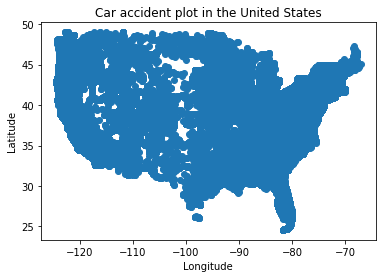

In [5]:
if not FINAL:
    plt.scatter(df["Start_Lng"], df["Start_Lat"])#, s=0.05, alpha=0.05)

    plt.title("Car accident plot in the United States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

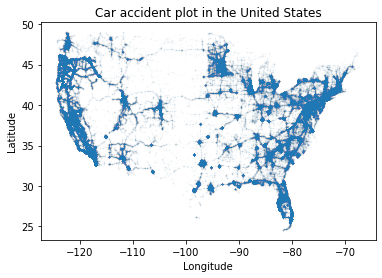

In [9]:
if not FINAL:
    plt.scatter(df["Start_Lng"], df["Start_Lat"], s=0.05, alpha=0.05)

    plt.title("Car accident plot in the United States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

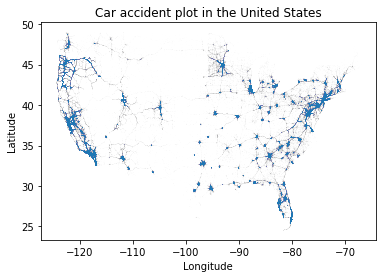

In [10]:
if not FINAL:
    plt.scatter(df["Start_Lng"], df["Start_Lat"], s=0.01, alpha=0.01)

    plt.title("Car accident plot in the United States")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

From visual inspection, I am comfortable saying there are 13 main clusters. However, there are many smaller concentrated dots, but these are difficult to count (seem to be ~100).

## Step 2.

With your chosen $k$, perform the k-means clustering on your data.
Plot clustering result so that each color has different color,
for example, cluster 1 in red, cluster 2 in blue, etc.

You can plot with different $k$ to find a better number of clusters.

**(Extra credit):** You can use silhouette method or elbow method to find the optimum k.


In [22]:
np.array([df["Start_Lng"],df["Start_Lat"]])

array([[ -83.09286,  -84.0628 ,  -84.52468, ..., -117.84779, -118.40302,
        -117.23092],
       [  40.10891,   39.86542,   39.10266, ...,   33.77545,   33.99246,
          34.13393]])

In [24]:
from sklearn.mixture import GaussianMixture

data = np.array([df["Start_Lng"], df["Start_Lat"]]).T
data.shape

(1516064, 2)

In [59]:
def get_sample(array, n_samples = 15161):
    indices = np.random.choice(list(range(len(array))), size=n_samples)
    return array[indices]


FI = (1 + 5**.5)/2 # golden ratio

# get hues, per an old favorite
# https://gamedev.stackexchange.com/questions/46463/how-can-i-find-an-optimum-set-of-colors-for-10-players
get_hues = lambda ii : colors.hsv_to_rgb(
    (
    (FI * ii) % 1,   # hue
    1.0,
    0.5
    )
)

# get_hues generates an RGB tuple for a given value (ii)
# using the equidistribution theorem,
# (FI % i) % 1
# will be equally distributed across [0,1),
# for any irrational FI.
# Per ~hash magic~, FI works best for maximum distinguishability.

In [60]:
# Sample our data to get a subset
some_data = get_sample(data)
print(some_data.shape)

(15161, 2)


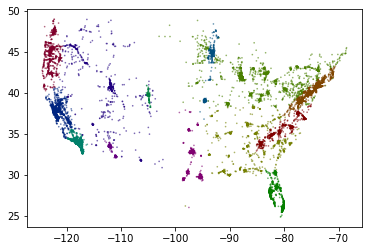

In [61]:
# for k = 13
K_CLUSTERS = 13

gmm = GaussianMixture(n_components = K_CLUSTERS)
gmm.fit(some_data)
labels = gmm.predict(some_data)

rgb_colors = [get_hues(index) for index in labels]

plt.scatter(
    some_data[:,0],
    some_data[:,1],
    c=rgb_colors,
    s=0.5,
    alpha=0.5
)

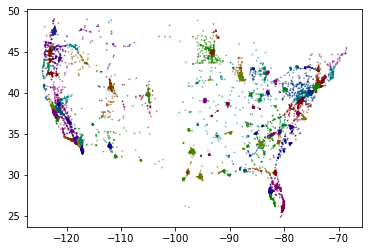

In [62]:
# for k = 100
K_CLUSTERS = 100

gmm = GaussianMixture(n_components = K_CLUSTERS)
gmm.fit(some_data)
labels = gmm.predict(some_data)

rgb_colors = [get_hues(index) for index in labels]

plt.scatter(
    some_data[:,0],
    some_data[:,1],
    c=rgb_colors,
    s=0.5,
    alpha=0.5
)

In [64]:
# Let's get the silhouette score

# e.g. k = 10

gmm = GaussianMixture(n_components=10)
gmm.fit(some_data)
labels = gmm.predict(some_data)

score = sklearn.metrics.silhouette_score(some_data, labels)
score

0.4665038168542998

In [71]:
MAX_K_TO_TEST = 200
GMMs = [None for _ in range(MAX_K_TO_TEST)]
scores = np.zeros(MAX_K_TO_TEST)
times = np.zeros(MAX_K_TO_TEST)


print("ii\tscore\ttime")
for ii in range(2,MAX_K_TO_TEST):
    start = time.time()
    gmm = GaussianMixture(n_components = ii + 1)
    gmm.fit(some_data)
    GMMs[ii] = gmm
    
    labels = gmm.predict(some_data)
    score = sklearn.metrics.silhouette_score(some_data, labels)
    scores[ii] = score
    
    total_time = time.time() - start
    print(f"{ii}\t{score:.3f}\t{total_time:.1f}s")
    times[ii] = time.time() - start

ii	score	time
2	0.600	2.0s
3	0.438	1.9s
4	0.421	1.9s
5	0.471	1.9s
6	0.396	2.0s
7	0.464	2.0s
8	0.440	2.2s
9	0.466	2.3s
10	0.511	2.0s
11	0.532	2.1s
12	0.537	2.2s
13	0.506	2.2s
14	0.497	2.4s
15	0.519	2.5s
16	0.457	2.6s
17	0.486	2.5s
18	0.494	2.7s
19	0.483	2.7s
20	0.493	2.8s
21	0.451	3.2s
22	0.541	2.8s
23	0.502	3.0s
24	0.437	3.7s
25	0.465	3.5s
26	0.440	4.2s
27	0.538	3.6s
28	0.490	3.8s
29	0.372	4.1s
30	0.466	3.7s
31	0.509	3.2s
32	0.380	4.7s
33	0.349	4.7s
34	0.420	3.5s
35	0.488	3.4s
36	0.485	3.8s
37	0.499	4.3s
38	0.394	4.1s
39	0.403	5.6s
40	0.419	4.3s
41	0.437	3.9s
42	0.484	4.4s
43	0.412	4.1s
44	0.423	3.9s
45	0.410	5.1s
46	0.408	5.8s
47	0.399	4.4s
48	0.437	4.1s
49	0.396	5.4s
50	0.390	5.5s
51	0.419	4.3s
52	0.428	4.9s
53	0.437	5.3s
54	0.435	5.0s
55	0.452	5.3s
56	0.452	4.6s
57	0.444	5.2s
58	0.427	4.8s
59	0.446	4.4s
60	0.446	5.0s
61	0.432	4.9s
62	0.480	4.7s
63	0.436	5.3s
64	0.438	5.5s
65	0.459	4.9s
66	0.416	5.7s
67	0.474	4.7s
68	0.447	4.6s
69	0.418	4.9s
70	0.424	5.7s
71	0.439	5.5s
72	0.459	5.3s


In [90]:
scores.argsort()[::-1][:10]

array([ 2, 22, 27, 12, 11, 15, 10, 31, 13, 23])

In [91]:
scores[scores.argsort()[::-1][:10]]

array([0.60015125, 0.54132341, 0.53829983, 0.53683692, 0.5316417 ,
       0.51880786, 0.51076617, 0.50897618, 0.50569991, 0.50189182])

... Oh no. It seems that $k = 2$ is the best here (per the bonus metric), with the best runner-ups being:

1. 22
2. 27
3. 12
4. 11
5. 15
6. 10
7. 31
8. 13
9. 23


So, I'll choose **a value of $k = 12** for my clusters. The reason being:

1. This is a good, countable number of clusters
2. It still has a reasonably high score

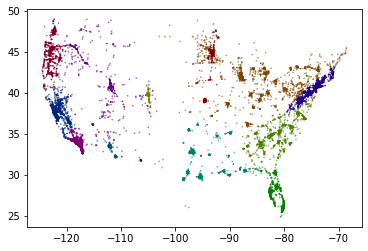

In [92]:
# for k = 100
K_CLUSTERS = 12

gmm = GaussianMixture(n_components = K_CLUSTERS)
gmm.fit(some_data)
labels = gmm.predict(some_data)

rgb_colors = [get_hues(index) for index in labels]

plt.scatter(
    some_data[:,0],
    some_data[:,1],
    c=rgb_colors,
    s=0.5,
    alpha=0.5
)

In [96]:
# now let's plot labels over the entire data
labels = gmm.predict(data)

IndexError: list index out of range

In [103]:
# pre-index hues, since color.hsv_to_rgb is **slow**
hues = [tuple(get_hues(ii)) for ii in range(12)]
rgb_colors = [hues[index] for index in labels]

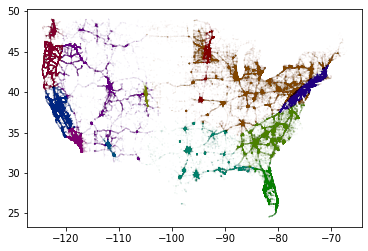

In [106]:
plt.scatter(
    data[:,0],
    data[:,1],
    c=rgb_colors,
    s=0.05,
    alpha=0.05
)

## Step 3.

Calculate the centroid (mean of x axis, mean of y axis) of each cluster
and radii that covers 90 % of data of the cluster. 

In [108]:
n_samp

1516064

In [111]:
len(data[labels == 1])

178801

In [112]:
n_samp = len(data)

Xcen  = np.zeros(12)
Ycen  = np.zeros(12)

In [117]:
data[labels == 0][:,0].mean()

-93.56210008265356

In [129]:
n_samp = len(data)

Xcen  = np.zeros(12)
Ycen  = np.zeros(12)

distances = []


for label in range(12):
    Xs = data[labels == label][:,0]
    Ys = data[labels == label][:,1]
    
    # get the center
    Xcen[label] = Xs.mean()
    Ycen[label] = Ys.mean()
    
    # sort these, and get the distance at the 90th index
    distance = ((Xs - Xs.mean())**2 + (Ys - Ys.mean())**2)**.5
    index_marking_90percent = int(len(distance) * .9)
    
    distances.append(np.sort(distance)[index_marking_90percent+1])

    

In [131]:
Xs

array([-115.67847 , -115.586776, -115.591689, ..., -119.483502,
       -120.399344, -120.400948])

In [132]:
Ys

array([34.72136 , 32.679239, 32.679525, ..., 42.049151, 40.37486 ,
       40.370829])

In [133]:
distances

[4.650207222959988,
 2.095659719459486,
 5.035466674188011,
 1.28337860182091,
 5.2789960057915,
 10.678010726937924,
 3.086730357509175,
 2.437512793548415,
 2.8682017620745497,
 1.2586656013974504,
 0.8092407035740076,
 8.136625703187391]

## Step 4.

Plot the circles centered at the centroid with radius calculated in Step 3
on top of the plot created from Step 2.
Mark the centroid with ‘X’.

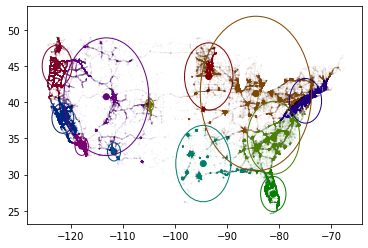

In [150]:
plt.scatter(Xcen, Ycen, c=hues)

# https://stackoverflow.com/questions/9215658/plot-a-circle-with-pyplot
for ii in range(12):
    circle = plt.Circle((Xcen[ii], Ycen[ii]), distances[ii], fill=False, color=hues[ii])
    plt.gca().add_patch(circle)
    

plt.scatter(
    data[:,0],
    data[:,1],
    c=rgb_colors,
    s=0.04,
    alpha=0.04
)

## Step 5.

In a markdown cell, discuss the goodness of your chosen $k$,
i.e., if you think what you have is the best or close to the best.

I think this is an appropriate size for analysis and for human understanding. The value of 2 (found through silhouette method) was bad, so I chose a value that falls "close" to the method.

## Step 6.

Repeat steps 2 ~ 5, using GMM with the EM clustering method.
In this case, calculate covariance matrix for each cluster instead of radius.
Show the values.

## Step 7.

Using a markdown cell, compare the outcomes from Step 6 with Step 4
and discuss which clustering method is better for your data.

## Step 8 (Extra credit)

Plot 2D Gaussian curve calculated in Step 6
as shown in the 2D GMM with EM examples in the lecture slides.

# Part 2: K-means and GMM

This part is to continuously help you do the term project
by making you include visualization of k-means and GMM clustering methods in your Dashboard. 

# Step 1.

Publish the visualizations you have done in Part 1 to your Dashboard “privately” for now.

## Step 2.

Take a screenshot (screen clip) of your Dashboard and include it in a markdown cell
so that you succeeded in publishing your Part I plots in your Dashboard publication.

The URL should demonstrate that you can publish your Dashboard on the public VM.

You should kill your publication after you are done with the screenshot
since you do not make your Dashboard public yet.

You are only showing that you can publish Dashboard on a third party machine.